In [1]:
%load_ext autoreload
%autoreload 2
import os
os.chdir('/home/jorge/thesis')

import torch
from text3d2video.utilities.camera_placement import turntable_extrinsics
from text3d2video.utilities.mesh_processing import normalize_meshes
from pytorch3d.io import load_obj, load_objs_as_meshes
from pytorch3d.renderer import FoVPerspectiveCameras

mesh_path = "data/meshes/mixamo-human.obj"
device = "cuda"

# read mesh
verts, faces, aux = load_obj(mesh_path)
verts_uvs = aux.verts_uvs.to(device)
faces_uvs = faces.textures_idx.to(device)

mesh = load_objs_as_meshes([mesh_path], device=device)
mesh = normalize_meshes(mesh)

R, T = turntable_extrinsics(dists=1, angles=0, elev=0)
camera = FoVPerspectiveCameras(device=device, R=R, T=T, fov=60)

torch.is_grad_enabled()

/home/jorge/miniconda3/envs/thesis4/lib/python3.9/site-packages/pytorch3d/io/obj_io.py:546: UserWarning: No mtl file provided
  warnings.warn("No mtl file provided")


True

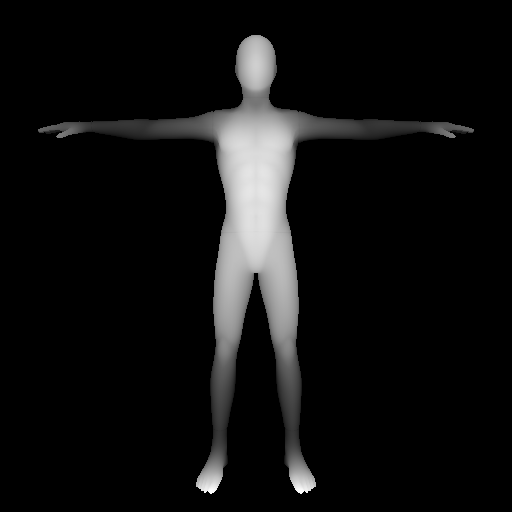

In [2]:
from text3d2video.rendering import render_depth_map

with torch.no_grad():
    depth = render_depth_map(mesh, camera)

depth[0]

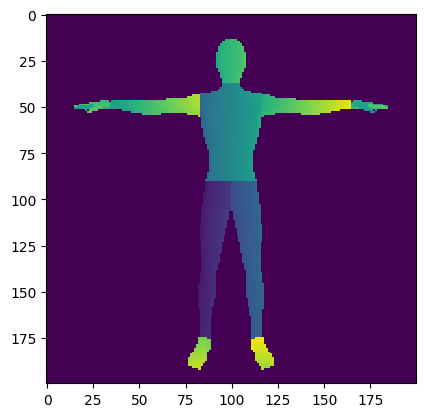

In [3]:
from matplotlib import pyplot as plt
from text3d2video.rendering import make_mesh_rasterizer
from pytorch3d.ops import interpolate_face_attributes

resolution = 200
rasterizer = make_mesh_rasterizer(resolution=resolution)
fragments = rasterizer(mesh, cameras=camera)

faces_verts_uvs = verts_uvs[faces_uvs]

mask = fragments.pix_to_face >= 0
mask = mask[0, :, :, 0]

pixel_uvs = interpolate_face_attributes(
    fragments.pix_to_face, fragments.bary_coords, faces_verts_uvs
)[0, :, :, 0, :]

plt.imshow(pixel_uvs[..., 0].cpu(), interpolation='nearest')

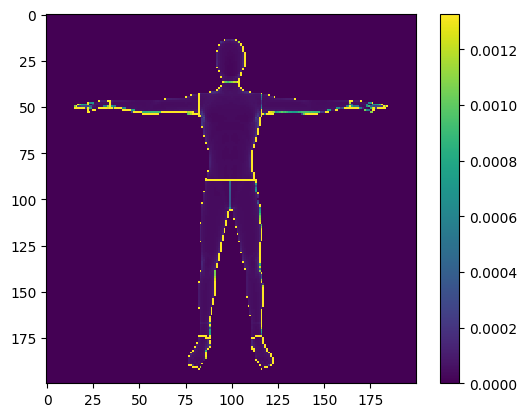

In [5]:
import numpy as np

duv_dx = torch.zeros_like(pixel_uvs)
duv_dy = torch.zeros_like(pixel_uvs)

for x in range(resolution):
    for y in range(resolution):
        masked = mask[x, y]
        uv = uv_coord = pixel_uvs[x, y]

        next_x_coord = (x + 1, y)
        if next_x_coord[0] < resolution:
            uv_next_x = pixel_uvs[next_x_coord]
            duv_dx[x, y] = uv - uv_next_x
        
        next_y_coord = (x, y + 1)
        if next_y_coord[1] < resolution:
            uv_next_y = pixel_uvs[next_y_coord]
            duv_dy[x, y] = uv - uv_next_y

du_dx = duv_dx[..., 0]
du_dy = duv_dy[..., 0]
dv_dx = duv_dx[..., 1]
dv_dy = duv_dy[..., 1]

negative_jacobian = torch.abs(du_dx * dv_dy - du_dy * dv_dx)


quality = negative_jacobian

vmax = np.percentile(quality.cpu().numpy(), 99)
plt.imshow(quality.cpu(), interpolation='nearest', vmax=vmax)

plt.colorbar()